In [12]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import torchvision
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Define emotion labels and number of classes
emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']
num_classes = len(emotions)

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx] if self.labels is not None else None
        if self.transform:
            image = self.transform(image)
        return (image, label) if label is not None else image


In [14]:
train_dir = 'data/train'
file_names = []
labels = []

for label, emotion in enumerate(emotions):
    emotion_dir = os.path.join(train_dir, emotion)
    for img_file in os.listdir(emotion_dir):
        file_path = os.path.join(emotion_dir, img_file)
        file_names.append(file_path)
        labels.append(label)

train_files, val_files, train_labels, val_labels = train_test_split(file_names, labels, test_size=0.15, random_state=42)


In [15]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [16]:
train_dataset = EmotionDataset(train_files, train_labels, transform=transform_train)
val_dataset = EmotionDataset(val_files, val_labels, transform=transform_val)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)


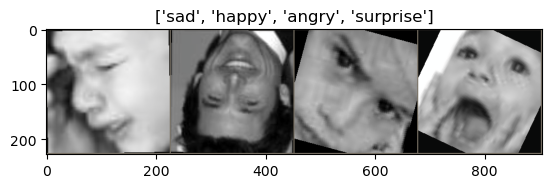

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(DataLoader(train_dataset, batch_size=4, shuffle=True)))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[emotions[x] for x in classes])


In [18]:
#model = models.swin_t(weights='IMAGENET1K_V1')
#model.head = nn.Linear(model.head.in_features, num_classes)
#model = model.to(device)

import torch.nn.functional as F

class SwinEmotionModel(nn.Module):
    def __init__(self, num_classes):
        super(SwinEmotionModel, self).__init__()
        self.swin = models.swin_t(weights='IMAGENET1K_V1')
        self.swin.head = nn.Sequential(
            nn.Dropout(0.7),  
            nn.Linear(self.swin.head.in_features, num_classes)
        )

    def forward(self, x):
        x = self.swin(x)
        return x

model = SwinEmotionModel(num_classes=num_classes).to(device)


In [19]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [20]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau


criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Initialize the learning rate scheduler
#scheduler = StepLR(optimizer, step_size=10, gamma=0.7)  # lr is decreased by a factor of 0.1 every 10 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)



Epoch 0/39
----------
train Loss: 1.3769 Acc: 0.4029
val Loss: 1.0279 Acc: 0.5933
Current learning rate: 0.000100
Epoch 1/39
----------
train Loss: 1.0845 Acc: 0.5595
val Loss: 0.8679 Acc: 0.6686
Current learning rate: 0.000100
Epoch 2/39
----------
train Loss: 0.9541 Acc: 0.6236
val Loss: 0.7134 Acc: 0.7359
Current learning rate: 0.000100
Epoch 3/39
----------
train Loss: 0.8400 Acc: 0.6764
val Loss: 0.7062 Acc: 0.7345
Current learning rate: 0.000100
Epoch 4/39
----------
train Loss: 0.7615 Acc: 0.7086
val Loss: 0.6696 Acc: 0.7469
Current learning rate: 0.000100
Epoch 5/39
----------
train Loss: 0.7111 Acc: 0.7336
val Loss: 0.6025 Acc: 0.7805
Current learning rate: 0.000100
Epoch 6/39
----------
train Loss: 0.6526 Acc: 0.7561
val Loss: 0.5687 Acc: 0.7901
Current learning rate: 0.000100
Epoch 7/39
----------
train Loss: 0.6159 Acc: 0.7685
val Loss: 0.6232 Acc: 0.7710
Current learning rate: 0.000100
Epoch 8/39
----------
train Loss: 0.5770 Acc: 0.7879
val Loss: 0.6009 Acc: 0.7813
Curren

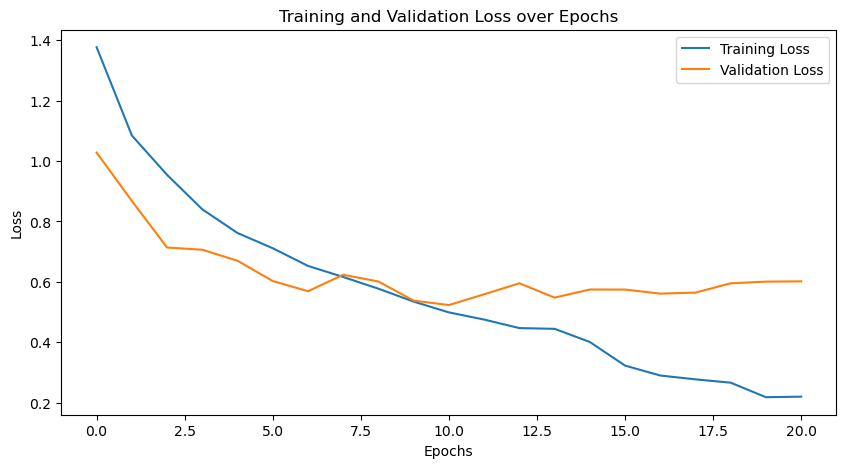

In [21]:
import matplotlib.pyplot as plt

num_epochs = 40  # Number of epochs

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in (train_dl if phase == 'train' else val_dl):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dataset if phase == 'train' else val_dataset)
        epoch_acc = running_corrects / len(train_dataset if phase == 'train' else val_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)
            scheduler.step(epoch_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')


print('Training complete')

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'swin_transformer_emotion_model.pth')


In [22]:
import pandas as pd

test_dir = 'data/test'
test_files = [os.path.join(test_dir, img_file) for img_file in os.listdir(test_dir)]

test_dataset = EmotionDataset(test_files, transform=transform_val)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
results = []

for inputs in test_dl:
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        results.extend(preds)

results_df = pd.DataFrame({'Id': [os.path.basename(file) for file in test_files], 'emotions': [emotions[pred] for pred in results]})
results_df.to_csv('predictions_swin.csv', index=False)


Notes
- training on 10% eval test set incl. data augmentation with 30 epochs achieved ~81,7% Kaggle F1-score (Best model yet)
    - training with LR-scheduler (StepLR every 10 epochs by 0.1) - oddly validation score of ~85% was achieved after 30 epochs, but kaggle F1 just ~81,5%
        - what to do? - try again next with slightly adapted StepLR (step_size=5, gamma=0.7) - again validation score of ~85% after 30 epochs but kaggle of just 81%
                - increase val set to 20% again... maybe that helps -> not really - kaggle score of ~81,7% again, but validation score of ~83% after 30 epochs
                       - added regularization (dropout layer) & changed optimizer to AdamW (val set still 20%) - val acc of ~83% but kaggle just ~81,1%
                               - BEST MODEL YET: add LR scheduling based on Plateau (not on fix epochs) + set val set to 10% again - val acc of ~86% but kaggle just ~81,9% 
                                       - exact same model, but no lr scheduling to check if discrepancy is still occuring (val score vs kaggle) - ~82% val score, ~82% kaggle score
                                               - seems to be working without lr scheduling 
                                                       - find way to fix this to get lr scheduling working properly with goal of 85% accuracy...
                                                               - Adjust validation set to 15%, Adding L2 regularization (weight_decay=1e-4), increase dropout rate to 0.6, add flips to data augmentation, increase lr factor to 0.5 - again val acc of ~85% but kaggle just ~81,7% -> Still overfitting
                                                                       - increase dropout rate (0.7), increase epochs to 40, add early-stopping (stopped after 20 epochs) - val score ~82%, Kaggle 79,9%
                                                                            - removed early stopping again - commit to save best model yet - 81,9% Kaggle score
                                                                                - 
next up:
        - adjust batch-size
        - adjust model (dropout rate, learning rate etc.)
        - clarify why kaggle score is so much lower than validation score
        - try googling instead of AI